# Compact on-chip optical switch design optimization using DBS

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

The direct binary search (DBS) algorithm is an iterative optimization algorithm often used in image processing and has been adapted for use in photonic design. 

The steps in a DBS are typically as follows:

1. **Initialization**: Starting with an initial design, usually a binary representation of the photonic structure where each element (pixel or voxel) is either one material or another.

2. **Evaluation**: Simulating the optical performance of the current design using methods like finite-difference time-domain (FDTD) simulations.

3. **Modification**: Adjusting the design by flipping the state of specific elements (from one material to another) based on certain criteria, such as improving performance metrics like transmission efficiency.

4. **Iteration**: Repeating the evaluation and modification steps until a satisfactory design is reached or a certain number of iterations have been completed.

This process allows for the fine-tuning of photonic structures to achieve highly specific and efficient optical characteristics. The DBS algorithm is valued for its relative simplicity and effectiveness, especially in scenarios where gradient-based optimization is challenging.

This notebook demonstrates the design of an on-chip optical switch based on the phase change material Ge$_2$Sb$_2$Te$_5$ (GST) using the DBS algorithm. The design region is a square of 900 nm by 900 nm discretized into 9 by 9 pixels with a size of 100 nm. The 3 by 3 pixels at the center of the design region is GST. Other pixels can be either silicon or silica. The goal is to optimize the materials at each pixel such that the best switching performance is obtained. That is, we want to achieve the highest transmission possible when GST is in the amorphous state while the lowest transmission possible when GST is in the crystalline state. The notebook follows the work `Yin, K.; Gao, Y.; Shi, H.; Zhu, S. Inverse Design and Numerical Investigations of an Ultra-Compact Integrated Optical Switch Based on Phase Change Material. Nanomaterials 2023, 13, 1643.` [DOI: 10.3390/nano13101643](https://doi.org/10.3390/nano13101643).

<img src="img/optical_switch.png" width="450" alt="Schematic of the optical switch">

`Tidy3D` is a powerful tool for photonic design optimization due to its fast speed and high throughput. Besides DBS, we have demonstrated particle swarm optimizations of a [polarization beam splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/) and a [bullseye cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/), genetic algorithm optimization of an [on-chip reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GeneticAlgorithmReflector/), and CMA-ES optimization of a [waveguide S-bend](https://www.flexcompute.com/tidy3d/examples/notebooks/SbendCMAES/). Furthermore, we also have a growing list of gradient-based adjoint optimization examples including

1. [Mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/),

2. [Waveguide taper](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/),

3. [Metalens](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/),

4. [Waveguide bend](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin8WaveguideBend/), 

5. [Multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin9WDM/),

6. [Y-branch](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin10YBranchLevelSet/),

7. [MZI circuit](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin11CircuitMZI/),

8. [Light extractor](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin12LightExtractor/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web

## Simulation Setup

The simulation wavelength range is 1535 nm to 1565 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.535, 1.565, 11)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

For simplicity, we will use the silicon and oxide media directly from the [material library](../api/material_library.html#). The GST has two states: the crystalline state with a higher loss and an amorphous state with a lower loss. Since our wavelength range of interest is relatively narrow, we use the `from_nk` method to define the material responses of GST in two states. It's important to note that the defined refractive index is strictly accurate only at the given frequency. 

In [3]:
Si = td.material_library["cSi"]["Palik_Lossless"]
SiO2 = td.material_library["SiO2"]["Palik_Lossless"]

aGST = td.Medium.from_nk(n=3.98, k=0.0244, freq=freq0)
cGST = td.Medium.from_nk(n=6.49, k=1.054, freq=freq0)

The straight waveguide has a width of 400 nm and a thickness of 220 nm. The size of the pixels in the design region is 100 nm by 100 nm. There are 9 by 9 pixels in total but the 3 by 3 pixels at the center are fixed to GST. In the current version, we only support `Nx`, `Ny`, and `N_gst` being odd numbers.

In [4]:
w = 0.4  # width of the waveguide
t = 0.22  # thickness of the silicon
l = 1  # length of the waveguide in the simulation
Px = Py = 0.1  # pixel sizes in the x and y directions
Nx = 9  # number of pixels in the x direction
Ny = 9  # numbre of pixels in the y direction
N_gst = 3  # number of pixels for GST
buffer = 0.8  # buffer spacing

Now we want to characterize a design by a parameter vector $(x_1, x_2, ..., x_n)$, where $x_i$ represents the material at the i-th pixel and takes the value of either 0 (silica) or 1 (silicon). Due to the symmetry, we only focus on symmetric designs. Since the GST pixels are fixed, we have a total of `(Ny * Nx - N_gst * N_gst) // 2 + Nx // 2 - 1 = 39` tuneable pixels. That is, the length of the parameter vector is 39 in this case.

For easier structure construction, we define a helper function `parse_to_2d` that takes the parameter vector and parses it into a 2D array representing the design. With that, we define another helper function `create_design` to define the structures in the design region as well as the input and output straight waveguides.

In [5]:
def parse_to_2d(array_1d, Nx, Ny, N_gst):
    # ensure Ny, Nx, and N_gst are odd
    if Ny % 2 == 0 or Nx % 2 == 0 or N_gst % 2 == 0:
        raise ValueError("Nx, Ny, and N_gst must be odd numbers.")

    # calculate the number of changeable elements in the top half (including the middle row)
    num_elements_half = (Ny * Nx - N_gst * N_gst) // 2 + Nx // 2 - 1

    if len(array_1d) != num_elements_half:
        raise ValueError(f"1D array must have {num_elements_half} elements.")

    array_2d = np.zeros((Ny, Nx))

    idx_1d = 0
    for i in range(Ny):
        for j in range(Nx):
            # skip the fixed center
            if (Ny - N_gst) // 2 <= i < (Ny + N_gst) // 2 and (Nx - N_gst) // 2 <= j < (
                Nx + N_gst
            ) // 2:
                continue

            # Fill up to and including the middle row
            if i <= Ny // 2:
                array_2d[i, j] = array_1d[idx_1d]
                idx_1d += 1

                # Mirror the element to the symmetrical position, but not for the middle row
                if i < Ny // 2:
                    array_2d[Ny - 1 - i, j] = array_1d[idx_1d - 1]

    return array_2d


def create_design(pixels):

    # parse 1d parameter vector to 2d array
    pixels_2d = parse_to_2d(pixels, Nx, Ny, N_gst)

    # define geometry at each pixel
    geo = 0
    for i, row in enumerate(pixels_2d):
        for j, pixel in enumerate(row):
            if pixel == 1:
                geo += td.Box(
                    center=(l + Px / 2 + Px * j, (Ny - 1) / 2 * Py - Py * i, 0), size=(Px, Py, t)
                )

    # add input and output waveguides
    geo += td.Box(center=(0, 0, 0), size=(2 * l, w, t))
    geo += td.Box(center=(l + Nx * Px + l, 0, 0), size=(2 * l, w, t))

    # define structure from geometry
    design = td.Structure(geometry=geo, medium=Si)

    return design

To test the functions, we define a parameter vector of all 1s. This should define a design that is all silicon besides the 3 by 3 pixels at the center for GST. The plot confirms that it's working correctly.

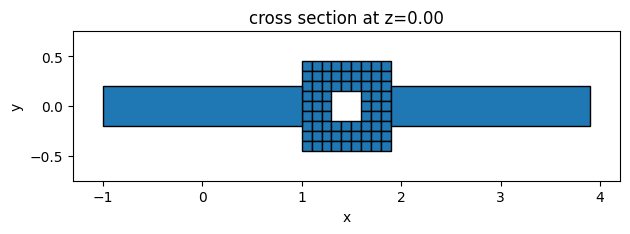

In [6]:
pixels = np.ones((Ny * Nx - N_gst * N_gst) // 2 + Nx // 2 - 1)
design = create_design(pixels)
design.plot(z=0)
plt.show()

Now we can define a function to create a [Simulation](../api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation) given a parameter vector and the state of the GST.

In [7]:
def make_sim(pixels, gst_state):

    # create silicon structures
    design = create_design(pixels)

    # add a mode source as excitation
    mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
    mode_source = td.ModeSource(
        center=(l / 2, 0, 0),
        size=(0, 4 * w, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )

    # add a mode monitor to measure transmission at the output waveguide
    mode_monitor = td.ModeMonitor(
        center=(Nx * Px + 1.5 * l, 0, 0),
        size=mode_source.size,
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode",
    )

    # create the GST pixels
    if gst_state == "c":
        gst = td.Structure(
            geometry=td.Box(center=(l + Px * Nx / 2, 0, 0), size=(N_gst * Px, N_gst * Py, t)),
            medium=cGST,
        )
    elif gst_state == "a":
        gst = td.Structure(
            geometry=td.Box(center=(l + Px * Nx / 2, 0, 0), size=(N_gst * Px, N_gst * Py, t)),
            medium=aGST,
        )
    else:
        raise ValueError("gst_state can only be 'a' or 'c'.")

    # define simulation domain size
    Lx = 2 * l + Nx * Px
    Ly = Ny * Py + 2 * buffer
    Lz = 10 * t

    # simulation domain box
    sim_box = td.Box.from_bounds(rmin=(0, -Ly / 2, -Lz / 2), rmax=(Lx, Ly / 2, Lz / 2))

    run_time = 1e-12  # simulation run time

    # define simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
        structures=[design, gst],
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=SiO2,
        symmetry=(0, -1, 1),
    )

    return sim

Visualize the simulation in 3D to check if the setup is correct.

In [8]:
sim = make_sim(pixels, "c")
sim.plot_3d()

## Optimization

The objective function is defined as the contrast between the transmissions when GST is in the amorphous and crystalline states. To evaluate it, we need to define two simulations with the same parameter vector but a different GST state, run the simulation in parallel, extract the transmission, and calculate the difference.

In [9]:
def objective_function(pixels):

    # define two simulations
    sim_a = make_sim(pixels, "a")
    sim_c = make_sim(pixels, "c")
    sims = {"a": sim_a, "c": sim_c}

    # define and submit a batch
    batch = web.Batch(simulations=sims, verbose=False)
    batch_results = batch.run(path_dir="data")

    # calculate transmission
    sim_data_a = batch_results["a"]
    sim_data_c = batch_results["c"]

    t_a = sim_data_a["mode"].amps.sel(direction="+").values
    T_a = np.mean(np.abs(t_a) ** 2)

    t_c = sim_data_c["mode"].amps.sel(direction="+").values
    T_c = np.mean(np.abs(t_c) ** 2)

    return T_a - T_c

We start the optimization using the parameter vector of all 1s. The objective function is evaluated to be just above 0.8.

In [10]:
initial_obj = objective_function(pixels)
print(f"Initial objective function is {initial_obj:.3f}.")

22:56:38 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:39 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Initial objective function is 0.812.


Since the DBS algorithm is pretty straightforward, we don't need to make sure of any external libraries. We can define the DBS optimizer directly. In the optimization, we flip the value of elements in the parameter vector one by one. If the flip leads to an improved objective function, we keep the flipped element. If no improvement is found, we revert back to the original value. One iteration ends when all elements of the parameter vector are flipped once and this can be done for multiple iterations. We can implement different termination conditions. For example, if no improvement is found or the improvement is smaller than a certain threshold between consecutive iterations, the optimization stops. Or if the objective function reaches a certain threshold value, the optimization stops. In this example, we simply monitor the improvement and terminate the optimization if no improvement is found within one iteration. 

In [11]:
def direct_binary_search(pixels, iterations):

    num_of_eval = 0  # number of objective function evaluations
    best_score = [initial_obj]  # best objective function values
    print(f"The initial objective function is {initial_obj:.3f}.")

    for i in range(iterations):
        print(f"Iteration {i+1} starts.")
        improvement = False  # keep track of if there is improvement within one iteration

        for idx in range(len(pixels)):
            # flip the current element
            pixels[idx] = 1 - pixels[idx]

            # Evaluate the new solution
            current_score = objective_function(pixels)
            num_of_eval += 1

            # if better, update best solution, else revert change
            if current_score > best_score[-1]:
                best_score.append(current_score)
                improvement = True
                print(
                    f"A best objective of {current_score:.3f} found after {num_of_eval} evaluation(s)."
                )

            else:
                best_score.append(best_score[-1])
                pixels[idx] = 1 - pixels[idx]  # revert change
        if not improvement:
            break

    return pixels, best_score

For simplicity, we only demonstrate the optimization for 1 iteration in this case. We tested more iterations and found that the second iteration only improved the performance very mildly. The third iteration showed no improvement at all. Within the first iteration, we improve the objective function by about 10%, which is quite significant.

In [12]:
pixel_opt, best_score = direct_binary_search(pixels, 1)

The initial objective function is 0.812.
Iteration 1 starts.


22:57:00 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.832 found after 1 evaluation(s).


22:57:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:22 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.859 found after 2 evaluation(s).


22:57:43 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:03 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:24 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:47 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:48 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.862 found after 6 evaluation(s).


22:59:08 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.870 found after 7 evaluation(s).


22:59:31 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.871 found after 8 evaluation(s).


22:59:52 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.882 found after 9 evaluation(s).


23:00:12 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:00:13 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.899 found after 10 evaluation(s).


23:00:38 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.915 found after 11 evaluation(s).


23:00:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:00 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:20 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.918 found after 13 evaluation(s).


23:01:41 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:42 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:02:05 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:02:06 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:02:27 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:02:48 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:02:49 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:03:10 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.922 found after 18 evaluation(s).


23:03:33 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:03:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:03:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:04:15 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:04:16 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:04:37 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:04:57 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:05:18 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.924 found after 24 evaluation(s).


23:05:39 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:05:40 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:06:00 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:06:01 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

A best objective of 0.927 found after 26 evaluation(s).


23:06:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:06:44 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:06:45 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:07:05 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:07:06 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:07:27 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:07:47 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:07:48 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:08:09 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:08:30 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:08:31 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:08:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:09:15 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:09:16 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:09:36 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:09:58 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:09:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:10:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:10:22 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:10:44 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:10:45 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Plot the best objective function as a function of the number of evaluations.

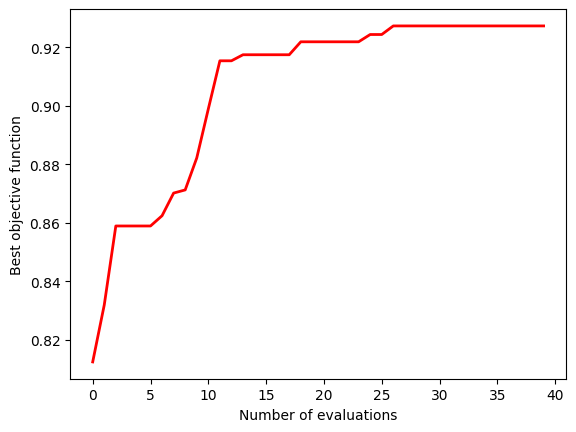

In [13]:
plt.plot(best_score, c="red", linewidth=2)
plt.xlabel("Number of evaluations")
plt.ylabel("Best objective function")
plt.show()

## Final Design

After the optimization, we can inspect the final design more closely. We rerun the simulations with an added [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) so we can visualize the switching behavior better. We didn't have a [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) during the optimization to minimize unnecessary data download. 

In [14]:
sim_a_opt = make_sim(pixels, "a")
sim_c_opt = make_sim(pixels, "c")

# add a field monitor to visualize field distribution at z=0
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

sim_a_opt = sim_a_opt.copy(update={"monitors": sim_a_opt.monitors + (field_monitor,)})
sim_c_opt = sim_c_opt.copy(update={"monitors": sim_c_opt.monitors + (field_monitor,)})

sims = {"a": sim_a_opt, "c": sim_c_opt}

batch_opt = web.Batch(simulations=sims, verbose=False)
batch_opt_results = batch_opt.run(path_dir="data")

Visualize the final design.

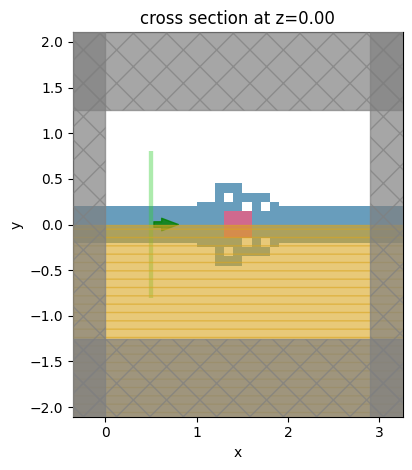

In [15]:
sim_a_opt.plot(z=0, monitor_alpha=0)
plt.show()

Plot the transmission spectra for the final design with GST at two states. A clear switching with >20 dB contrast is confirmed.

23:11:08 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

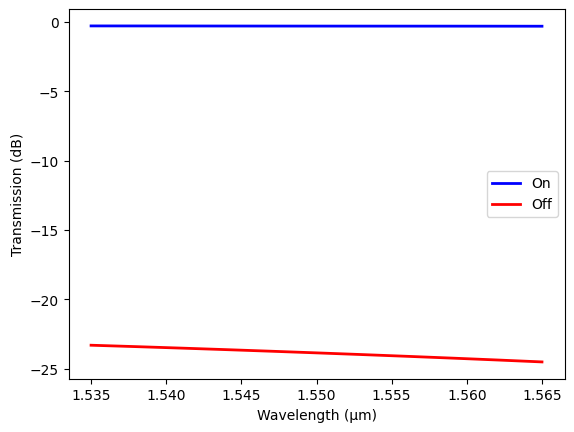

In [16]:
sim_data_a = batch_opt_results["a"]
sim_data_c = batch_opt_results["c"]

t_a = sim_data_a["mode"].amps.sel(direction="+").values
T_a = np.abs(t_a) ** 2

t_c = sim_data_c["mode"].amps.sel(direction="+").values
T_c = np.abs(t_c) ** 2

plt.plot(ldas, 10 * np.log10(T_a), c="blue", linewidth=2, label="On")
plt.plot(ldas, 10 * np.log10(T_c), c="red", linewidth=2, label="Off")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Transmission (dB)")
plt.legend()
plt.show()

Finally, plot the electric field norms to see the energy flow. When the GST is in the amorphous state (on state), the waveguide mode is transmitted with little loss. When the GST is in the crystalline state (off state), the transmission is cut off nearly completely. The result confirms that the optimized design functions very well as an optical switch while maintaining an ultra-compact footprint. 

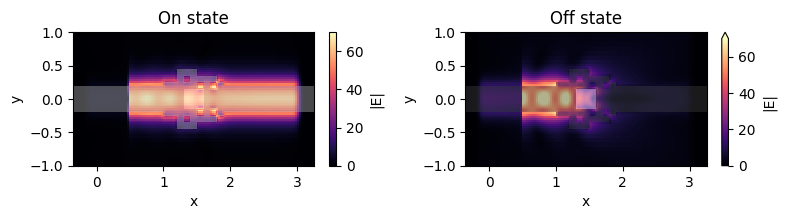

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2), tight_layout=True)
sim_data_a.plot_field(
    field_monitor_name="field", field_name="E", val="abs", ax=ax1, eps_alpha=0.4, vmin=0, vmax=70
)
sim_data_c.plot_field(
    field_monitor_name="field", field_name="E", val="abs", ax=ax2, eps_alpha=0.4, vmin=0, vmax=70
)
ax1.set_title("On state")
ax1.set_ylim(-1, 1)
ax2.set_title("Off state")
ax2.set_ylim(-1, 1)
plt.show()